In [1]:
import pandas as pd
import glob
import os
import json
import numpy as np
from  cycler import cycler
import fastplot
from collections import Counter, defaultdict
from statistics import mode
import re
import statsmodels.stats.proportion


CYCLER_LINESPOINTS=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]) +
                    cycler('marker', ['o', 's', 'v', 'd', '^' ]))

CYCLER_LINES=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]))

PLOT_ARGS = {"style":"latex", "grid":True, "figsize":(4.25,2.5), "rcParams":{'text.latex.preamble': r'\usepackage{libertine}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,2.75), "rcParams":{'text.latex.preamble': r'\usepackage{libertine}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

BEFORE_STR = "\\emph{Before-Accept}"
AFTER_STR = "\\emph{After-Accept}"

TRANSLATE_CATEGORIES = {"Computers Electronics and Technology": "Computers and Technology",
                        "Business and Consumer Services": "Business and Services",
                        "Heavy Industry and Engineering": "Industry and Engineering"}

COUNTRY_TRAD={"it":"Italy", "fr":"France", "de":"Germany", "es":"Spain", "uk":"UK", "us": "US"}

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
trackers = set( open("trackers-list.txt", "r").read().splitlines() )

similarweb_websites=defaultdict(set)
for c in ["it", "es", "fr", "de", "uk", "us"]:
    similarweb_websites[c] = set(open("similarweb/{}.txt".format(c), "r" ).read().splitlines()) 
    

In [4]:
bad_domains=set("co.uk co.jp co.hu co.il com.au co.ve .co.in com.ec com.pk co.th co.nz com.br com.sg com.sa \
com.do co.za com.hk com.mx com.ly com.ua com.eg com.pe com.tr co.kr com.ng com.pe com.pk co.th \
com.au com.ph com.my com.tw com.ec com.kw co.in co.id com.com com.vn com.bd com.ar \
com.co com.vn org.uk net.gr".split())

def getGood2LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]    
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return get3LD(fqdn)
    tln_array = names[-2:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

def get3LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    tln_array = names[-3:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

In [5]:
df = pd.read_csv("data/similarweb-from-it.csv")
df["sld"] = df["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df["tld"] = df["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  ) 

df_us = pd.read_csv("data/similarweb-from-us-ohio.csv")
df_us["sld"] = df_us["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df_us["tld"] = df_us["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  ) 

df_br = pd.read_csv("data/similarweb-from-br.csv")
df_br["sld"] = df_br["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df_br["tld"] = df_br["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  )

df_jp = pd.read_csv("data/similarweb-from-jp.csv")
df_jp["sld"] = df_jp["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df_jp["tld"] = df_jp["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  )

df_ca = pd.read_csv("data/similarweb-from-us-california.csv")
df_ca["sld"] = df_ca["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df_ca["tld"] = df_ca["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  )

In [6]:
for country in similarweb_websites:
    df[country] = (df.sld.isin(similarweb_websites[country])) | (df.tld.isin(similarweb_websites[country]))

for country in similarweb_websites:
    df_us[country] = (df_us.sld.isin(similarweb_websites[country])) | (df_us.tld.isin(similarweb_websites[country]))
    
for country in similarweb_websites:
    df_br[country] = (df_br.sld.isin(similarweb_websites[country])) | (df_br.tld.isin(similarweb_websites[country]))
    
for country in similarweb_websites:
    df_jp[country] = (df_jp.sld.isin(similarweb_websites[country])) | (df_jp.tld.isin(similarweb_websites[country]))
    
for country in similarweb_websites:
    df_ca[country] = (df_ca.sld.isin(similarweb_websites[country])) | (df_ca.tld.isin(similarweb_websites[country]))

In [7]:
similarweb_csv = pd.read_csv("similarweb/similarweb.csv")
similarweb_csv["category"] = similarweb_csv["category"].apply(lambda s: TRANSLATE_CATEGORIES[s] if s in TRANSLATE_CATEGORIES else s)

categories = defaultdict(set)

for row in similarweb_csv.itertuples():
    if row.category != "ALL" and row.country in {"it", "es", "fr", "de", "uk"} :
        categories[row.category].add(row.website)
        
for this_df in [df, df_us, df_br, df_jp, df_ca]:
    for category in categories:
        this_df[category] = (this_df.sld.isin(categories[category])) | (this_df.tld.isin(categories[category]))    

In [8]:
def get_trackers(s):
    d = json.loads(s)
    this_trackers = set()
    for c in d:
        if (c["domain"] in trackers or getGood2LD(c["domain"]) in trackers or get3LD(c["domain"]) in trackers) and c["expires"] > 0:
            this_trackers.add(getGood2LD(c["domain"]))
    return list(this_trackers)

for this_df in [df, df_us, df_br, df_jp, df_ca]:
    this_df["trackers_first"] = this_df["cookie_first"].apply(get_trackers)
    this_df["trackers_click"] = this_df["cookie_click"].apply(get_trackers)
    this_df["trackers_internal"] = this_df["cookie_internal"].apply(get_trackers)


In [9]:
def website_stats(this_df):
    num = len(this_df.index)
    trackers_first = set()
    trackers_click = set()
    trackers_internal = set()
    has_found_banner = False
    
    tp_first = set()
    tp_click = set()
    
    countries = { c:False for c in similarweb_websites.keys()}
    cats = { c:False for c in categories.keys()}
    #+ list(similarweb_websites.keys()) + list(categories.keys())
    
    
    for i, row in this_df.iterrows():

        trackers_first |= set(row.trackers_first)
        trackers_click |= set(row.trackers_click)
        trackers_internal |= set(row.trackers_internal)
        
        tp_first |= set([ getGood2LD(d) for d in json.loads(row.domains_first) if d != ""] )
        tp_click |= set([ getGood2LD(d) for d in json.loads(row.domains_click) if d != ""])
        
        for c in list(similarweb_websites.keys()):
            countries[c] |= row[c]

        for c in list(categories.keys()):
            cats[c] |= row[c]
            
        if row.has_found_banner:
            has_found_banner=True
        
    trackers_only_click = trackers_click - trackers_first
       
    return pd.Series({"count": num,
                      "trackers_first": trackers_first,
                      "trackers_click": trackers_click,
                      "trackers_only_click": trackers_only_click,
                      "trackers_internal": trackers_internal,
                      "tp_first": tp_first,
                      "tp_click": tp_click,
                      "has_found_banner": has_found_banner,
                      "onload_first": this_df["onload_first"].median(),
                      "onload_second": this_df["onload_second"].median(),
                      "rum_first": this_df["rum_first"].mean(),
                      "rum_second": this_df["rum_second"].mean(),
                      "objects_first": this_df["objects_first"].mean(),
                      "objects_second": this_df["objects_second"].mean(),
                      "bytes_first": this_df["bytes_first"].median(),
                      "bytes_second": this_df["bytes_second"].median(),
                      "byte_index_first": this_df["byte_index_first"].mean(),
                      "object_index_first": this_df["object_index_first"].mean(),
                      "byte_index_second": this_df["byte_index_second"].mean(),
                      "object_index_second": this_df["object_index_second"].mean(),
                      **countries, **cats
                     })

grouped = df.groupby(["sld"] ).apply(website_stats).reset_index()
grouped_us = df_us.groupby(["sld"] ).apply(website_stats).reset_index()
grouped_br = df_br.groupby(["sld"] ).apply(website_stats).reset_index()
grouped_jp = df_jp.groupby(["sld"] ).apply(website_stats).reset_index()
grouped_ca = df_ca.groupby(["sld"] ).apply(website_stats).reset_index()


print ("Websites from Europe", len(grouped))
print ("Websites from US", len(grouped_us))
print ("Websites from BR", len(grouped_br))

Websites from Europe 13159
Websites from US 13360
Websites from BR 11983


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


<Figure size 640x480 with 0 Axes>

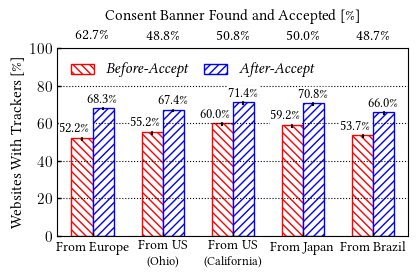

In [10]:
CYCLER_LINES_ALTERNATE=(cycler('color', ['r', 'b', 'r', 'b', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]))

tracker_first_it = grouped[ grouped[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_first"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_first").size()
tracker_click_it = grouped[ grouped[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_click"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_click").size()

tracker_first_us = grouped_us[ grouped_us[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_first"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_first").size()
tracker_click_us = grouped_us[ grouped_us[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_click"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_click").size()

tracker_first_br = grouped_br[ grouped_br[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_first"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_first").size()
tracker_click_br = grouped_br[ grouped_br[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_click"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_click").size()

tracker_first_jp = grouped_jp[ grouped_jp[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_first"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_first").size()
tracker_click_jp = grouped_jp[ grouped_jp[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_click"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_click").size()

tracker_first_ca = grouped_ca[ grouped_ca[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_first"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_first").size()
tracker_click_ca = grouped_ca[ grouped_ca[["it", "es", "fr", "de", "uk"]].any(axis=1) ] ["trackers_click"]\
                    .apply(len).apply(lambda n : n>0).reset_index().groupby("trackers_click").size()


tracker_first_it = tracker_first_it/sum(tracker_first_it)
tracker_click_it = tracker_click_it/sum(tracker_click_it)

tracker_first_us = tracker_first_us/sum(tracker_first_us)
tracker_click_us = tracker_click_us/sum(tracker_click_us)

tracker_first_br = tracker_first_br/sum(tracker_first_br)
tracker_click_br = tracker_click_br/sum(tracker_click_br)

tracker_first_jp = tracker_first_jp/sum(tracker_first_jp)
tracker_click_jp = tracker_click_jp/sum(tracker_click_jp)

tracker_first_ca = tracker_first_ca/sum(tracker_first_ca)
tracker_click_ca = tracker_click_ca/sum(tracker_click_ca)

all_trackers = pd.DataFrame( [[tracker_first_it[True]*100, tracker_click_it[True]*100 ],
                              [tracker_first_us[True]*100, tracker_click_us[True]*100 ],
                              [tracker_first_ca[True]*100, tracker_click_ca[True]*100 ],
                              [tracker_first_jp[True]*100, tracker_click_jp[True]*100 ],
                              [tracker_first_br[True]*100, tracker_click_br[True]*100 ],
                             ],
                           index = ["\\normalsize From Europe",
                                    "\\begin{center}\\normalsize From US\\\\{\\small (Ohio)}\\end{center}",
                                    "\\begin{center}\\normalsize From US\\\\{\\small (California)}\\end{center}",
                                    "\\normalsize From  Japan",
                                    "\\normalsize From  Brazil",
                                   ],
                           columns = [BEFORE_STR, AFTER_STR])


plot = fastplot.plot( all_trackers, None, 
               mode='bars_multi', grid_axis = "y", ylim = (0,100), #yticks = [(0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0),None],
               ylabel = "Websites With Trackers [\\%]",
               legend = True, legend_loc='upper left', legend_ncol=2, cycler = CYCLER_LINES_ALTERNATE,
               **PLOT_ARGS)

for p in plot.gca().patches[:len(all_trackers)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(all_trackers):len(all_trackers)*2]+ [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    
for i, row in enumerate(all_trackers.itertuples()):
    naive = row._1
    ca = row._2
    plot.text(i-0.25, naive + 3, "\\normalsize" + str (round(naive, 1)) + "\\%", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))
    plot.text(i+0.15, ca + 3, "\\normalsize" + str (round(ca, 1)) + "\\%",  ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))
    
for i, g in enumerate([grouped, grouped_us, grouped_ca, grouped_jp, grouped_br]):
    g =  g[ g[["it", "es", "fr", "de", "uk"]].any(axis=1) ] 
    n = round(len(g[g["has_found_banner"]].index)/len(g.index)*100,1)
    plot.text(i, 105, "{}\\%".format(n), ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))
    
plot.text(2, 115, "Consent Banner Found and Accepted [\\%]", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))

N=grouped["sld"].nunique()

err = all_trackers[[BEFORE_STR, AFTER_STR]].applymap(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*N/100,N,0.05) ]  )
for i, tup in enumerate(err.itertuples()):
    plot.gca().plot( (i-0.15,i-0.15), (tup[1]), linestyle="-", color="black"  )
    plot.gca().plot( (i+0.15,i+0.15), (tup[2]), linestyle="-", color="black" )
plot.subplots_adjust(left=0.125, bottom=0.1, right=0.95, top=0.85) 
plot.savefig("plots/cookieaccept_compare_countries.pdf", bbox_inches = "tight")
plot.show()